In [79]:
from notebook.services.config import ConfigManager
cm = ConfigManager()

cm.update('livereveal', {
              'width': 1000,
              'height': 600,
              'scroll': True,
})

{'width': 1000, 'height': 600, 'scroll': True}

# Analysis of Housing Rental Market
## Impact of Unemployment and Median Income on Rental Rates
>This study is a review of the Rental Market and what, if any impact Unemployment Rates and Median Income have on pricing.  The data curated for this study spans from 2013 to 2018.  Additional Observations have been provided for further context.


In [80]:
import matplotlib.pyplot as plt
import datetime as dt
import time
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas.plotting import scatter_matrix
import seaborn as sns
import folium
import geopandas as gpd
import scipy.stats as stats

## Curated Data Sets

In [81]:
#Describe Dataset here
filename = 'data\zillow\MortgageRateConventionalFixed.csv'
mortgage_rates_src = pd.read_csv(filename)

#Describe Dataset here
filename = 'data\zillow\Affordability_Income_2018Q4.csv'
affordability_income_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Median Rental Price - Single Family Residence
filename = 'data\zillow\City_MedianRentalPrice_Sfr.csv'
median_rental_price_sfr_src = pd.read_csv(filename,skipinitialspace=True)

#Median Rental Price Per Square Foot - Single Family Residence
filename = 'data\zillow\City_MedianRentalPricePerSqft_Sfr.csv'
median_rental_price_sfr_sqft_src = pd.read_csv(filename,skipinitialspace=True)

#Unemployment Rate - 20 years 
filename = 'data/unemployment_rate_20_years.csv'
unemployment_rate_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Monthly Listing all homes - city
filename = 'data/zillow/MonthlyListings_NSA_AllHomes_City.csv'
monthly_listings_allhomes_city_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Sale Counts - city
filename = 'data/zillow/Sale_Counts_City.csv'
monthly_sale_counts_city_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Sale prices - city
filename = 'data/zillow/Sale_Prices_City.csv'
monthly_sale_prices_city_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Describe Dataset here
filename = 'data\zillow\Affordability_Wide_2019Q2_Public.csv'
affordability_index_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Unemployment Rate - by state 
filename = 'data/unemployment_rate_by_state.csv'
unemployment_rate_state_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True) 

#    #Median Rental Price - Multi-Family Residence
#    filename = 'data\zillow\City_MedianRentalPrice_Mfr5Plus.csv'
#    median_rental_price_mfr_src = pd.read_csv(filename,skipinitialspace=True)

#    #Median Rental Price Per Square Foot - Multi-Family Residence
#    filename = 'data\zillow\City_MedianRentalPricePerSqft_Mfr5Plus.csv'
#    median_rental_price_mfr_sqft_src = pd.read_csv(filename,skipinitialspace=True)

#    #Rental Index Per Square Foot - All Homes
#    filename = 'data\zillow\City_ZriPerSqft_AllHomes.csv'
#    rental_index_all_sqft_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#    #Median Value - All Homes
#    filename = 'data\zillow\City_Zhvi_AllHomes.csv'
#    median_value_all_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#    #Median Value Per Square Foot - All Homes
#    filename = 'data\zillow\City_MedianValuePerSqft_AllHomes.csv'
#    median_value_all_sqft_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#    #Count of Home Sales
#    filename = 'data\zillow\Sale_Counts_City.csv'
#    sales_count_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#    #rental vacancy Rate - 10 years quarterly
#    filename = 'data/rental_vacancy_rate_10_yrs.csv'
#    rental_vacancy_rate_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Variable for use in the notebook
housing_crash_date = ['2008','12']
state_geo = 'data/folium/us-states.json'

# Annual Metrics Munging
### Median Rental Rate - sqft - Monthly

In [82]:
#hideme
median_rental_price_sfr_sqft = median_rental_price_sfr_sqft_src.copy()
median_rental_price_sfr_sqft.drop(columns=['State','RegionName','Metro','CountyName','SizeRank'],inplace=True)
median_rental_price_sfr_sqft.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in median_rental_price_sfr_sqft.columns],names=['Year','Month'])
median_rental_price_sfr_sqft = pd.DataFrame(median_rental_price_sfr_sqft.median()).reset_index()
median_rental_price_sfr_sqft.columns=['Year','Month','RentalRateSqFt']
median_rental_price_sfr_sqft['Year'] = median_rental_price_sfr_sqft['Year'].astype(int)
median_rental_price_sfr_sqft['Month'] = median_rental_price_sfr_sqft['Month'].astype(int)
median_rental_price_sfr_sqft.head()

Year  Month  RentalRateSqFt
0  2010      1        0.670390
1  2010      2        0.776057
2  2010      3        0.786121
3  2010      4        0.784661
4  2010      5        0.785475

# Annual Metrics Munging
### Median Rental Rate - Monthly

In [83]:
median_rental_price_sfr = median_rental_price_sfr_src.copy()
median_rental_price_sfr.drop(columns=['State','RegionName','Metro','CountyName','SizeRank'],inplace=True)
median_rental_price_sfr.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in median_rental_price_sfr.columns],names=['Year','Month'])
median_rental_price_sfr = pd.DataFrame(median_rental_price_sfr.median()).reset_index()
median_rental_price_sfr.columns=['Year','Month','RentalRate']
median_rental_price_sfr['Year'] = median_rental_price_sfr['Year'].astype(int)
median_rental_price_sfr['Month'] = median_rental_price_sfr['Month'].astype(int)
#median_rental_price_sfr.set_index('Year',inplace=True)
median_rental_price_sfr.head()

Year  Month  RentalRate
0  2010      1      925.00
1  2010      2     1300.00
2  2010      3     1236.25
3  2010      4     1250.00
4  2010      5     1250.00

# Annual Metrics Munging
### Mortgage Rates - Monthly

In [84]:
mortgage_rates = mortgage_rates_src.copy()
mortgage_rates = mortgage_rates.drop(columns='TimePeriod')
mortgage_rates = mortgage_rates.rename(columns={'MortgageRateConventionalFixed':'MortgageRate'})
mortgage_rates['Date'] = pd.to_datetime(mortgage_rates['Date'], format='%Y-%m-%d')
mortgage_rates['Year'] = pd.DatetimeIndex(mortgage_rates['Date']).year
mortgage_rates['Month'] = pd.DatetimeIndex(mortgage_rates['Date']).month
mortgage_rates = mortgage_rates.drop(columns='Date')
mortgage_rates = mortgage_rates.groupby(['Year','Month']).median().reset_index()
mortgage_rates['Year'] = mortgage_rates['Year'].astype(int)
mortgage_rates['Month'] = mortgage_rates['Month'].astype(int)
#mortgage_rates.set_index('Year',inplace=True)
mortgage_rates.head()

Year  Month  MortgageRate
0  2011      6          4.36
1  2011      7          4.45
2  2011      8          4.12
3  2011      9          3.97
4  2011     10          4.06

# Annual Metrics Munging
### Unemployment Rates - Monthly

In [85]:
unemployment_rate = pd.DataFrame(unemployment_rate_src.copy())#.reset_index()
unemployment_rate = unemployment_rate.rename(columns={'LNS14000024':'UnemploymentRate'})
unemployment_rate['Date'] = pd.to_datetime(unemployment_rate['DATE'], format='%Y-%m-%d')
unemployment_rate['Year'] = pd.DatetimeIndex(unemployment_rate['Date']).year
unemployment_rate['Month'] = pd.DatetimeIndex(unemployment_rate['Date']).month
unemployment_rate = unemployment_rate.drop(columns='Date')
unemployment_rate = unemployment_rate.groupby(['Year','Month']).median().reset_index()
unemployment_rate['Year'] = unemployment_rate['Year'].astype(int)
unemployment_rate['Month'] = unemployment_rate['Month'].astype(int)
unemployment_rate.head()

Year  Month  UnemploymentRate
0  2009      8               8.9
1  2009      9               9.1
2  2009     10               9.3
3  2009     11               9.2
4  2009     12               9.2

# Annual Metrics Munging
### Median Income - Monthly

In [86]:
affordability_income = affordability_income_src.copy()
affordability_income['State'] = affordability_income["RegionName"].apply(lambda x: "".join(x.split(',')[1:]))
#affordability_income['City'] = affordability_income["RegionName"].apply(lambda x: "".join(x.split(',')[0]))
affordability_income.drop(columns=['RegionName','RegionID','SizeRank'],inplace=True)
affordability_income = affordability_income.set_index('State')
affordability_income.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in affordability_income.columns],names=['Year','Month'])
#affordability_income = affordability_income.groupby('State').sum()#.median()
affordability_income = pd.DataFrame(affordability_income.median()).reset_index()
affordability_income.columns=['Year','Month','MedianIncome']
affordability_income['Year'] = affordability_income['Year'].astype(int)
affordability_income['Month'] = affordability_income['Month'].astype(int)
##median_rental_price_sfr.set_index('Year',inplace=True)
affordability_income.head()

Year  Month  MedianIncome
0  1979      3     15575.635
1  1979      6     15916.245
2  1979      9     16213.680
3  1979     12     16502.270
4  1980      3     16842.490

# Annual Metrics Munging
### Home Sales - Monthly
>*this dataset includes small cities so we're going to total by state before doing median*

In [87]:
monthly_sale_counts_city = monthly_sale_counts_city_src.copy()
monthly_sale_counts_city.drop(columns=['RegionName','RegionID','SizeRank'],inplace=True)
monthly_sale_counts_city = monthly_sale_counts_city.set_index('StateName')
monthly_sale_counts_city.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in monthly_sale_counts_city.columns],names=['Year','Month'])
#this dataset includes small cities so we're going to total by state before doing median
monthly_sale_counts_city = monthly_sale_counts_city.groupby('StateName').sum()#.median()
monthly_sale_counts_city = pd.DataFrame(monthly_sale_counts_city.median()).reset_index()
monthly_sale_counts_city.columns=['Year','Month','SaleCounts']
monthly_sale_counts_city['Year'] = monthly_sale_counts_city['Year'].astype(int)
monthly_sale_counts_city['Month'] = monthly_sale_counts_city['Month'].astype(int)
##median_rental_price_sfr.set_index('Year',inplace=True)
monthly_sale_counts_city.head()


Year  Month  SaleCounts
0  2008      3      1939.0
1  2008      4      2168.0
2  2008      5      2365.0
3  2008      6      2694.0
4  2008      7      2726.0

# Annual Metrics Munging
### Home Sales Prices - Monthly

In [88]:
monthly_sale_prices_city = monthly_sale_prices_city_src.copy()
monthly_sale_prices_city.drop(columns=['StateName','RegionName','RegionID','SizeRank'],inplace=True)
monthly_sale_prices_city.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in monthly_sale_prices_city.columns],names=['Year','Month'])
monthly_sale_prices_city = pd.DataFrame(monthly_sale_prices_city.median()).reset_index()
monthly_sale_prices_city.columns=['Year','Month','SalePrices']
monthly_sale_prices_city['Year'] = monthly_sale_prices_city['Year'].astype(int)
monthly_sale_prices_city['Month'] = monthly_sale_prices_city['Month'].astype(int)
#median_rental_price_sfr.set_index('Year',inplace=True)
monthly_sale_prices_city.head()


Year  Month  SalePrices
0  2008      3    246400.0
1  2008      4    242600.0
2  2008      5    236600.0
3  2008      6    233900.0
4  2008      7    230900.0

# Annual Metrics Munging
### Home Listings - Monthly
>*this dataset includes small cities so we're going to total by state before doing median*


In [89]:
monthly_listings_allhomes_city = monthly_listings_allhomes_city_src.copy()
monthly_listings_allhomes_city.drop(columns=['RegionName','RegionID','SizeRank'],inplace=True)
monthly_listings_allhomes_city = monthly_listings_allhomes_city.set_index('StateName')
monthly_listings_allhomes_city.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in monthly_listings_allhomes_city.columns],names=['Year','Month'])
monthly_listings_allhomes_city = monthly_listings_allhomes_city.groupby('StateName').sum()
monthly_listings_allhomes_city = pd.DataFrame(monthly_listings_allhomes_city.median()).reset_index()
monthly_listings_allhomes_city.columns=['Year','Month','Listings']
monthly_listings_allhomes_city['Year'] = monthly_listings_allhomes_city['Year'].astype(int)
monthly_listings_allhomes_city['Month'] = monthly_listings_allhomes_city['Month'].astype(int)
#median_rental_price_sfr.set_index('Year',inplace=True)
monthly_listings_allhomes_city.head()


Year  Month  Listings
0  2013      1   18950.5
1  2013      2   18459.0
2  2013      3   19230.5
3  2013      4   20254.0
4  2013      5   21811.0

# Annual Metrics Munging
### Consolidated Annual Metrics
>*MedianIncome is a quarterly figure.  A fillna backfill method was chosen to address NaN values and a left merge was used to respect the consolidated range of availble dates of the set.

In [90]:
#build metrics set from first candidate df
metrics_yearly = median_rental_price_sfr_sqft
metrics_yearly['Date'] = metrics_yearly['Month'].map(str)+ '-' +metrics_yearly['Year'].map(str)
metrics_yearly['Date'] = pd.to_datetime(metrics_yearly['Date'], format='%m-%Y')#.dt.strftime('%Y-Q%q')
metrics_yearly['Quarter'] = metrics_yearly['Date'].dt.quarter
#set our column order early so we don't have to deal with it later
metrics_yearly = metrics_yearly[['Date','Year','Month','Quarter','RentalRateSqFt']]
#merge in any other metrics we need
metrics_yearly = metrics_yearly.merge(unemployment_rate, left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(median_rental_price_sfr, left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(mortgage_rates,left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(monthly_listings_allhomes_city,left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(monthly_sale_counts_city,left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(monthly_sale_prices_city,left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(affordability_income,how='left',left_on=['Year','Month'], right_on=['Year','Month']).fillna(method='bfill')
metrics_yearly = metrics_yearly.dropna(how='any')
metrics_yearly.set_index('Date',inplace=True,drop=True)
#metrics_yearly['Quarter'] = metrics_yearly['Date']
#metrics_yearly = metrics_yearly.resample('Q').mean()
metrics_yearly.head()

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MortgageRate  Listings  SaleCounts  SalePrices  \
Date                                                                     
2013-01-01      1250.0          3.46   18950.5      2118.0    189500.0   
2013-02-01      1250.0          3.58   18459.0      1870.0    188400.0   
2013-03-01      1288.0          3.59   19230.5      2348.0    189300.0   
2013-04-01      1295.0          3.42   20254.0      2951.0    191500.0   
2013-05-01      1300.0          3.59   21811.0      3331.0    192150.0   

            MedianIncome  
Date                      
2013-01-01     48236.435  
2013-02-01     48236.435  
2013-03-01     48236.435  
2013-04-01     48455.295  
2013-05-01     48455.295

In [91]:
#hideme
metrics_yearly.describe()

Year      Month   Quarter  RentalRateSqFt  UnemploymentRate  \
count    72.00000  72.000000  72.00000       72.000000         72.000000   
mean   2015.50000   6.500000   2.50000        0.910004          4.877778   
std       1.71981   3.476278   1.12588        0.068399          1.102522   
min    2013.00000   1.000000   1.00000        0.817461          3.400000   
25%    2014.00000   3.750000   1.75000        0.852494          4.000000   
50%    2015.50000   6.500000   2.50000        0.895257          4.600000   
75%    2017.00000   9.250000   3.25000        0.978971          5.625000   
max    2018.00000  12.000000   4.00000        1.033592          7.400000   

        RentalRate  MortgageRate      Listings   SaleCounts     SalePrices  \
count    72.000000     72.000000     72.000000    72.000000      72.000000   
mean   1465.475694      3.988194  19086.125000  3846.916667  217338.888889   
std     110.281803      0.353184   2543.764653   917.341440   16210.267183   
min    1250.000000      3.410000  13548.500000  1870.000000  188400.000000   
25%    1395.000000      3.747500  17494.750000  3294.250000  203650.000000   
50%    1456.000000      3.920000  19019.250000  3791.500000  216075.000000   
75%    1582.187500      4.245000  20829.375000  4571.750000  228350.000000   
max    1650.000000      4.850000  23971.500000  5933.000000  248900.000000   

       MedianIncome  
count     72.000000  
mean   51727.052195  
std     2531.378580  
min    48236.435000  
25%    49470.261250  
50%    51609.077500  
75%    54045.258750  
max    55962.065107

# Analysis of Consolidated Metrics
### Rental Rates vs Unemployment by Year

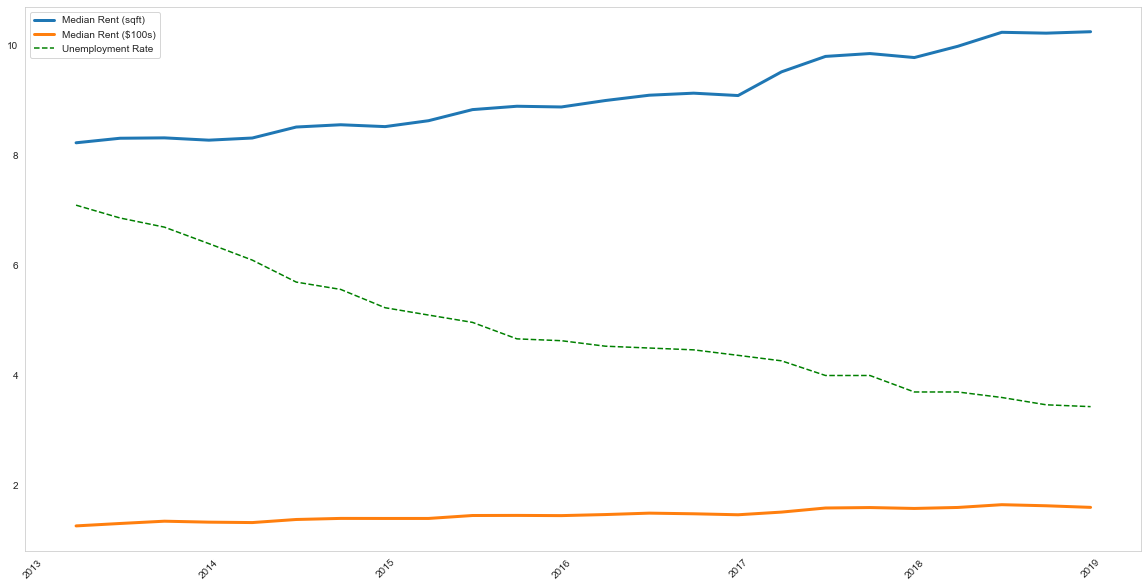

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MortgageRate  Listings  SaleCounts  SalePrices  \
Date                                                                     
2013-01-01      1250.0          3.46   18950.5      2118.0    189500.0   
2013-02-01      1250.0          3.58   18459.0      1870.0    188400.0   
2013-03-01      1288.0          3.59   19230.5      2348.0    189300.0   
2013-04-01      1295.0          3.42   20254.0      2951.0    191500.0   
2013-05-01      1300.0          3.59   21811.0      3331.0    192150.0   

            MedianIncome  
Date                      
2013-01-01     48236.435  
2013-02-01     48236.435  
2013-03-01     48236.435  
2013-04-01     48455.295  
2013-05-01     48455.295

In [92]:
#hideme
title = 'Rental Rates vs Unemployment by Year'

fig, ax1 = plt.subplots(figsize=(20,10))

df = metrics_yearly.resample('Q').mean()
x_axis = df.index

#OUR HYPOTHSIS METRICS
y_axis = df['RentalRateSqFt']*10
ax1.plot(x_axis,y_axis, label='Median Rent (sqft)', linestyle='solid',linewidth=3)
 
y_axis = df['RentalRate']/1000
ax1.plot(x_axis,y_axis, label='Median Rent ($100s)',linestyle='solid',linewidth=3)

#ax2 = ax1.twinx()
y_axis = df['UnemploymentRate']
ax1.plot(x_axis,y_axis, label='Unemployment Rate', c='g',linestyle='dashed')


# Turn on the grid
ax1.grid()
ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')
plt.xticks(rotation=45)

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
metrics_yearly.head()

![Rental Rates vs Unemployment by Year](figures/Rental_Rates_vs_Unemployment_by_Year.png)


# Analysis of Consolidated Metrics
### Rental Rates vs Median Income

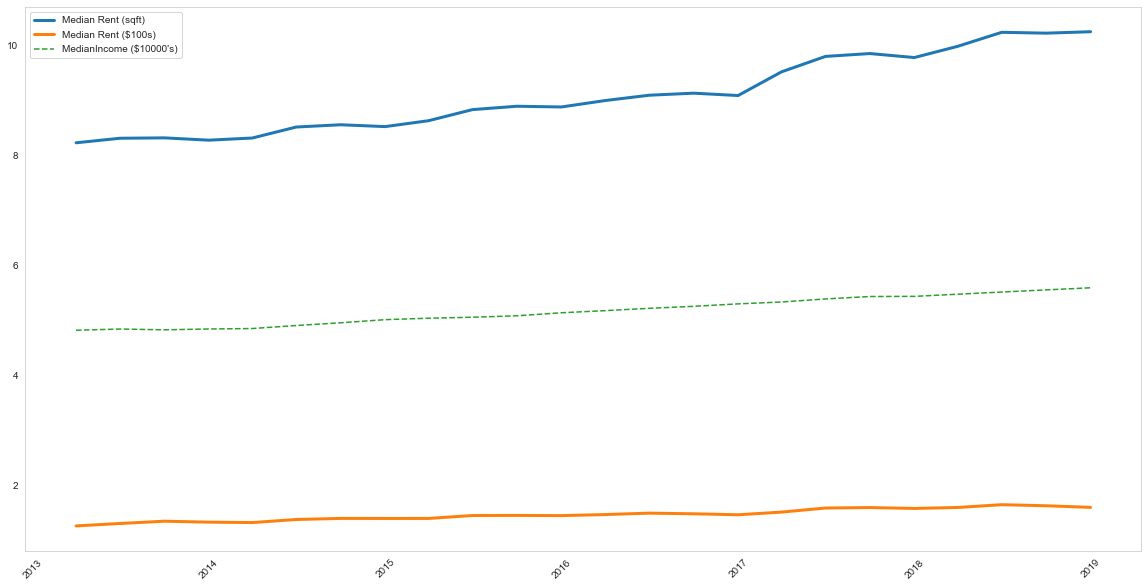

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MortgageRate  Listings  SaleCounts  SalePrices  \
Date                                                                     
2013-01-01      1250.0          3.46   18950.5      2118.0    189500.0   
2013-02-01      1250.0          3.58   18459.0      1870.0    188400.0   
2013-03-01      1288.0          3.59   19230.5      2348.0    189300.0   
2013-04-01      1295.0          3.42   20254.0      2951.0    191500.0   
2013-05-01      1300.0          3.59   21811.0      3331.0    192150.0   

            MedianIncome  
Date                      
2013-01-01     48236.435  
2013-02-01     48236.435  
2013-03-01     48236.435  
2013-04-01     48455.295  
2013-05-01     48455.295

In [93]:
#hideme
title = 'Rental Rates vs Median Income by Year'

fig, ax1 = plt.subplots(figsize=(20,10))


df = metrics_yearly.resample('Q').mean()
x_axis = df.index

#OUR HYPOTHSIS METRICS
y_axis = df['RentalRateSqFt']*10
ax1.plot(x_axis,y_axis, label='Median Rent (sqft)', linestyle='solid',linewidth=3)

y_axis = df['RentalRate']/1000
ax1.plot(x_axis,y_axis, label='Median Rent ($100s)',linestyle='solid',linewidth=3)

#ax2 = ax1.twinx()
y_axis = df['MedianIncome']/10000
ax1.plot(x_axis,y_axis, label=f"MedianIncome ($10000's)",linestyle='dashed')


# Turn on the grid
ax1.grid()
ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')
plt.xticks(rotation=45)

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
metrics_yearly.head()

![Rental Rates vs Median Income by Year](figures/Rental_Rates_vs_Median_Income_by_Year.png)

# Analysis of Consolidated Metrics
### Rental Rates vs All Observations by Year

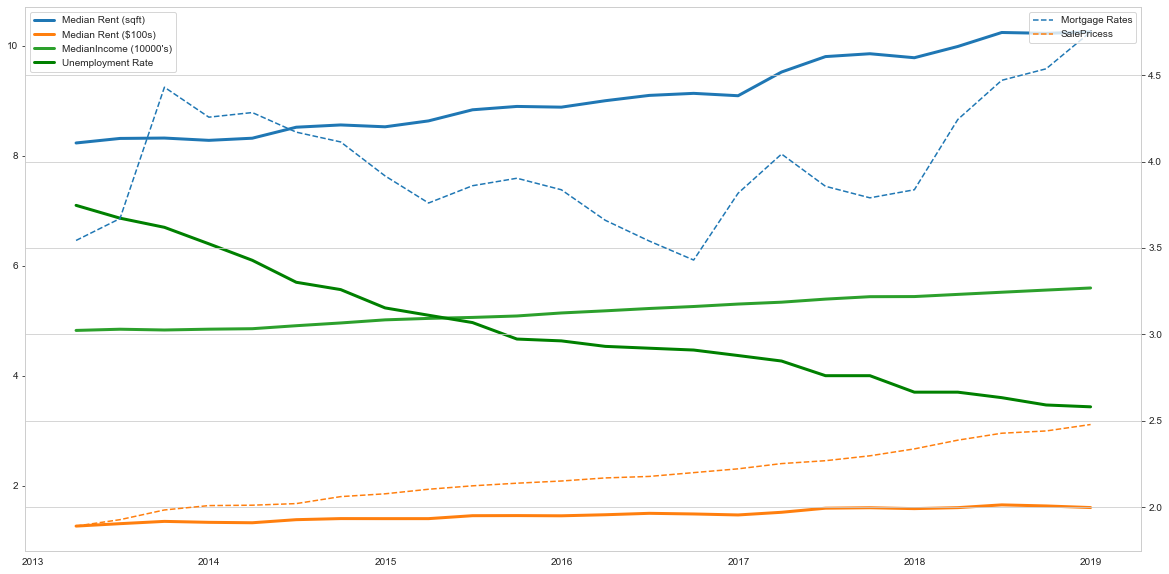

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MortgageRate  Listings  SaleCounts  SalePrices  \
Date                                                                     
2013-01-01      1250.0          3.46   18950.5      2118.0    189500.0   
2013-02-01      1250.0          3.58   18459.0      1870.0    188400.0   
2013-03-01      1288.0          3.59   19230.5      2348.0    189300.0   
2013-04-01      1295.0          3.42   20254.0      2951.0    191500.0   
2013-05-01      1300.0          3.59   21811.0      3331.0    192150.0   

            MedianIncome  
Date                      
2013-01-01     48236.435  
2013-02-01     48236.435  
2013-03-01     48236.435  
2013-04-01     48455.295  
2013-05-01     48455.295

In [94]:
#hideme
title = 'Rental Rates vs All Observations by Year'

fig, ax1 = plt.subplots(figsize=(20,10))

df = metrics_yearly.resample('Q').mean()
x_axis = df.index

#OUR HYPOTHSIS METRICS
y_axis = df['RentalRateSqFt']*10
ax1.plot(x_axis,y_axis, label='Median Rent (sqft)', linestyle='solid',linewidth=3)

y_axis = df['RentalRate']/1000
ax1.plot(x_axis,y_axis, label='Median Rent ($100s)',linestyle='solid',linewidth=3)

y_axis = df['MedianIncome']/10000
ax1.plot(x_axis,y_axis, label=f"MedianIncome (10000's)",linestyle='solid',linewidth=3)

ax2 = ax1.twinx()
y_axis = df['UnemploymentRate']
ax1.plot(x_axis,y_axis, label='Unemployment Rate', c='g',linestyle='solid',linewidth=3)

#OTHER FACTORS AS POTENTIAL INFLUENCERS
y_axis = df['MortgageRate']
ax2.plot(x_axis,y_axis, label='Mortgage Rates', linestyle='dashed')

y_axis = df['SalePrices']/100000
ax2.plot(x_axis,y_axis, label='SalePricess', linestyle='dashed')

# Turn on the grid
ax1.grid()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
metrics_yearly.head()

![Rental Rates vs All Observations by Year](figures/Rental_Rates_vs_All_Observations_by_Year.png)

# Analysis of Consolidated Metrics
### Scatter Matrix of All Observations

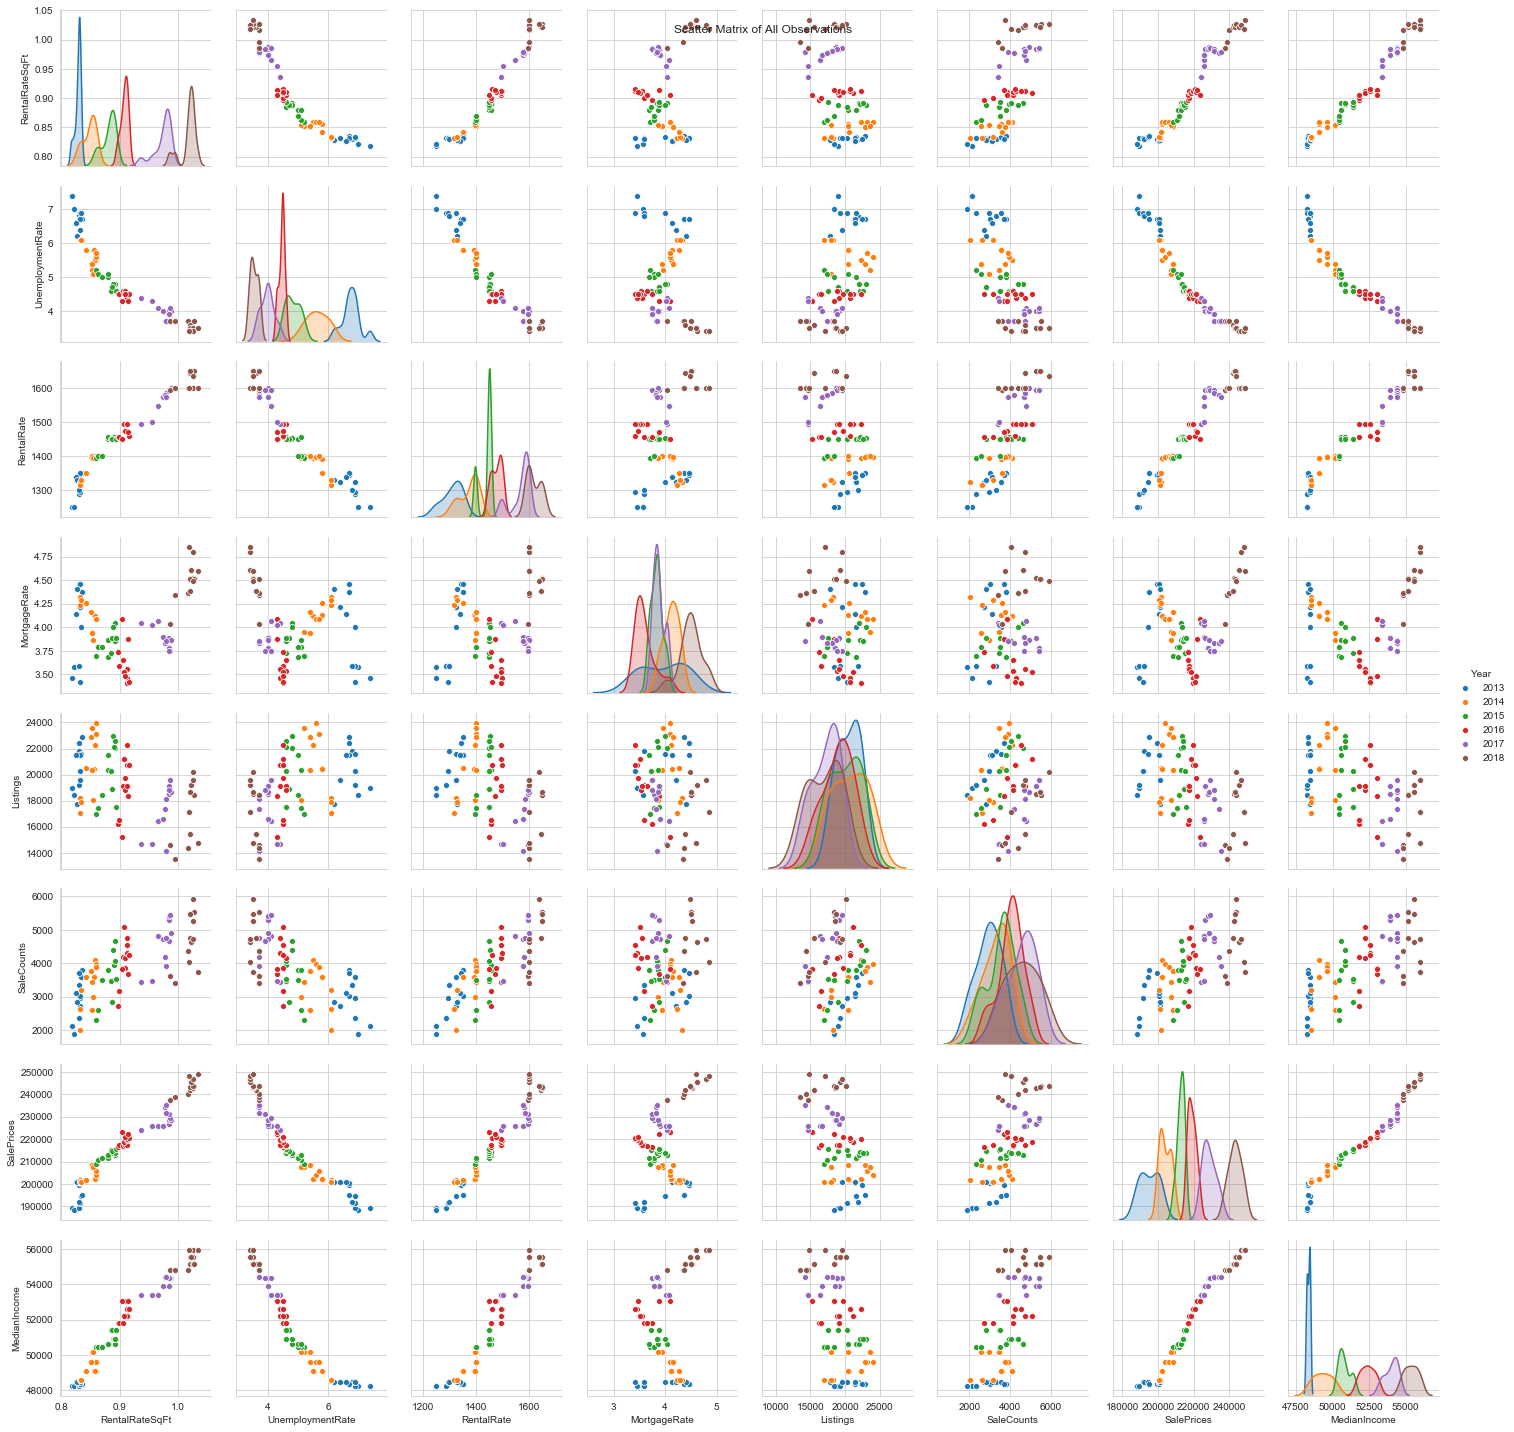

In [95]:
#hideme
title = 'Scatter Matrix of All Observations'

df = metrics_yearly.drop(columns=['Month','Quarter'])

cols = [col for col in df.columns if col not in ['Year','Month','Quarter']]

sns.pairplot(df, hue="Year", vars=cols)
plt.suptitle(f'{title}')


# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

# Show the Figure
plt.show()

![Scatter Matrix of All Observations](figures/Scatter_Matrix_of_All_Observations.png)

# Analysis of Consolidated Metrics
### Scatter Matrix of Core Observations

In [96]:
metrics_yearly_core =  metrics_yearly.filter(items=['Year','Month','Quarter','RentalRateSqFt','UnemploymentRate','RentalRate','MedianIncome'])
metrics_yearly_core.head()

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MedianIncome  
Date                                  
2013-01-01      1250.0     48236.435  
2013-02-01      1250.0     48236.435  
2013-03-01      1288.0     48236.435  
2013-04-01      1295.0     48455.295  
2013-05-01      1300.0     48455.295

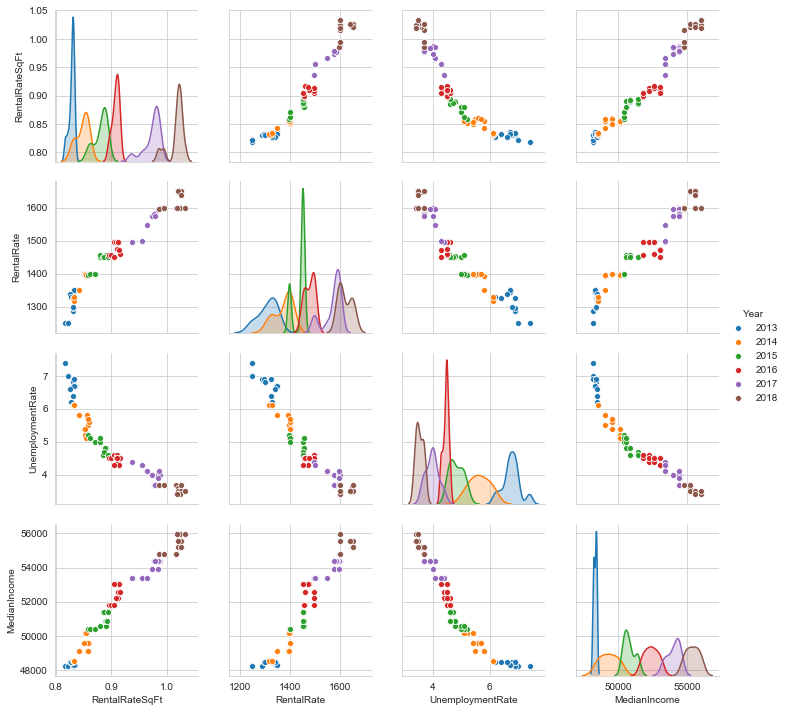

In [97]:
#hideme
title = 'Scatter Matrix of Core Observations'


df = metrics_yearly_core.copy()#.drop(columns=['Month','Quarter'])

sns.pairplot(df, hue="Year", vars=['RentalRateSqFt','RentalRate','UnemploymentRate','MedianIncome'])

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

# Show the Figure
plt.show()

![Scatter Matrix of Core Observations](figures/Scatter_Matrix_of_Core_Observations.png)

# Analysis of Consolidated Metrics
### RentalRateSqFt vs UnemploymentRate - Regression

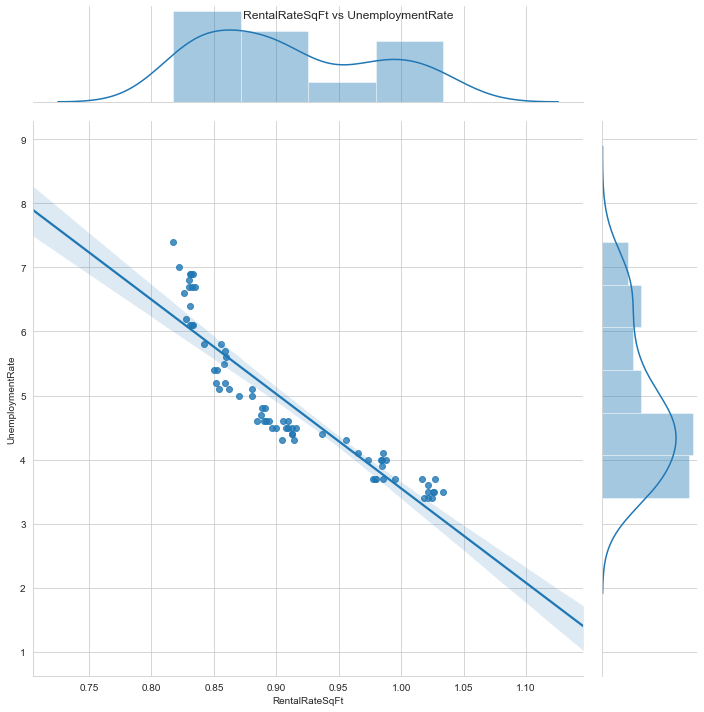

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MortgageRate  Listings  SaleCounts  SalePrices  \
Date                                                                     
2013-01-01      1250.0          3.46   18950.5      2118.0    189500.0   
2013-02-01      1250.0          3.58   18459.0      1870.0    188400.0   
2013-03-01      1288.0          3.59   19230.5      2348.0    189300.0   
2013-04-01      1295.0          3.42   20254.0      2951.0    191500.0   
2013-05-01      1300.0          3.59   21811.0      3331.0    192150.0   

            MedianIncome  
Date                      
2013-01-01     48236.435  
2013-02-01     48236.435  
2013-03-01     48236.435  
2013-04-01     48455.295  
2013-05-01     48455.295

In [98]:
#hideme
title = 'RentalRateSqFt vs UnemploymentRate'

df = metrics_yearly.copy()

sns.set_style("whitegrid")
sns.set_style({'axes.grid':True})

sns.jointplot(x='RentalRateSqFt',y='UnemploymentRate',data=df, kind='reg', height=10)

plt.suptitle(f'{title}')

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
df.head()

![RentalRateSqFt vs UnemploymentRate](figures/RentalRateSqFt_vs_UnemploymentRate.png)

# Analysis of Consolidated Metrics
### RentalRateSqFt vs MedianIncome - Regression

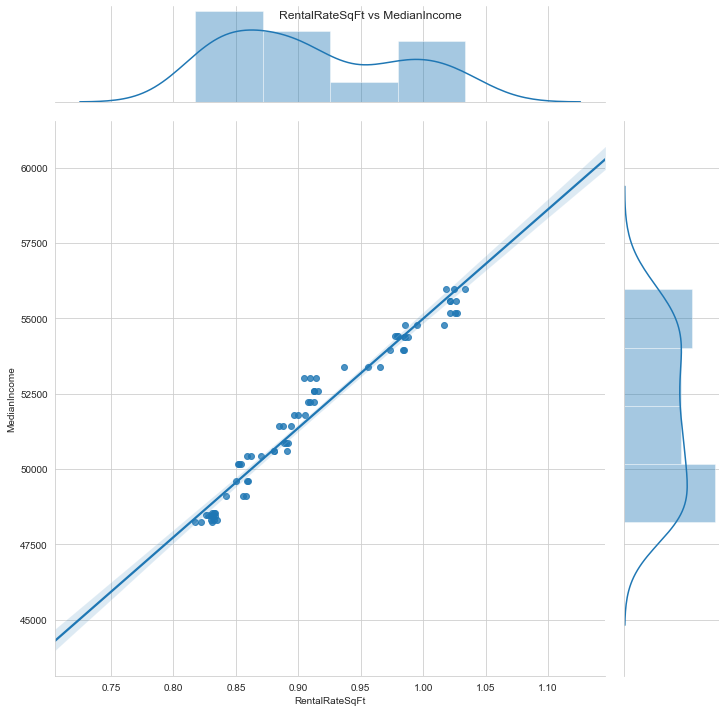

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MortgageRate  Listings  SaleCounts  SalePrices  \
Date                                                                     
2013-01-01      1250.0          3.46   18950.5      2118.0    189500.0   
2013-02-01      1250.0          3.58   18459.0      1870.0    188400.0   
2013-03-01      1288.0          3.59   19230.5      2348.0    189300.0   
2013-04-01      1295.0          3.42   20254.0      2951.0    191500.0   
2013-05-01      1300.0          3.59   21811.0      3331.0    192150.0   

            MedianIncome  
Date                      
2013-01-01     48236.435  
2013-02-01     48236.435  
2013-03-01     48236.435  
2013-04-01     48455.295  
2013-05-01     48455.295

In [99]:
#hideme
title = 'RentalRateSqFt vs MedianIncome'

df = metrics_yearly.copy()

sns.set_style("whitegrid")
sns.set_style({'axes.grid':True})

sns.jointplot(x='RentalRateSqFt',y='MedianIncome',data=df, kind='reg', height=10)

plt.suptitle(f'{title}')

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
df.head()

![RentalRateSqFt vs MedianIncome](figures/RentalRateSqFt_vs_MedianIncome.png)

# Analysis of Consolidated Metrics
### Unemployment Rates by Year

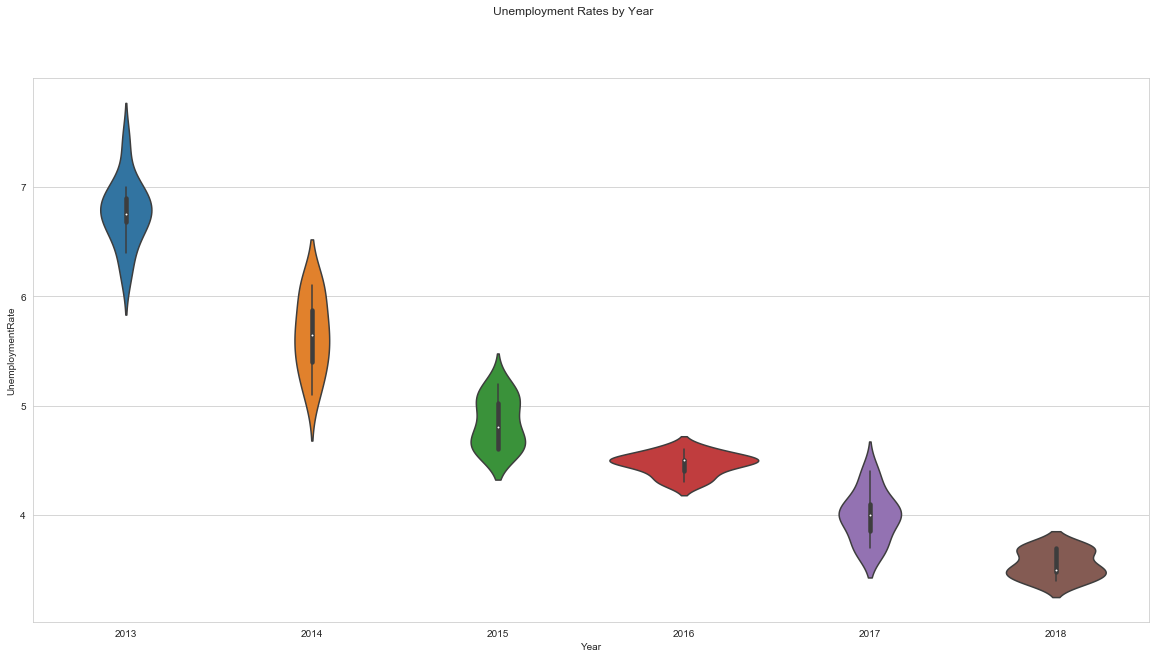

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MortgageRate  Listings  SaleCounts  SalePrices  \
Date                                                                     
2013-01-01      1250.0          3.46   18950.5      2118.0    189500.0   
2013-02-01      1250.0          3.58   18459.0      1870.0    188400.0   
2013-03-01      1288.0          3.59   19230.5      2348.0    189300.0   
2013-04-01      1295.0          3.42   20254.0      2951.0    191500.0   
2013-05-01      1300.0          3.59   21811.0      3331.0    192150.0   

            MedianIncome  
Date                      
2013-01-01     48236.435  
2013-02-01     48236.435  
2013-03-01     48236.435  
2013-04-01     48455.295  
2013-05-01     48455.295

In [100]:
#hideme
title = 'Unemployment Rates by Year'

plt.figure(figsize=(20,10))

sns.set_style("whitegrid")
sns.set_style({'axes.grid':True})

df = metrics_yearly.copy()

sns.violinplot(x=df['Year'],y=df['UnemploymentRate'],data=df)

plt.suptitle(f'{title}')

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
df.head()

![Unemployment Rates by Year](figures/Unemployment_Rates_by_Year.png)

# Analysis of Consolidated Metrics
### MedianIncome by Year

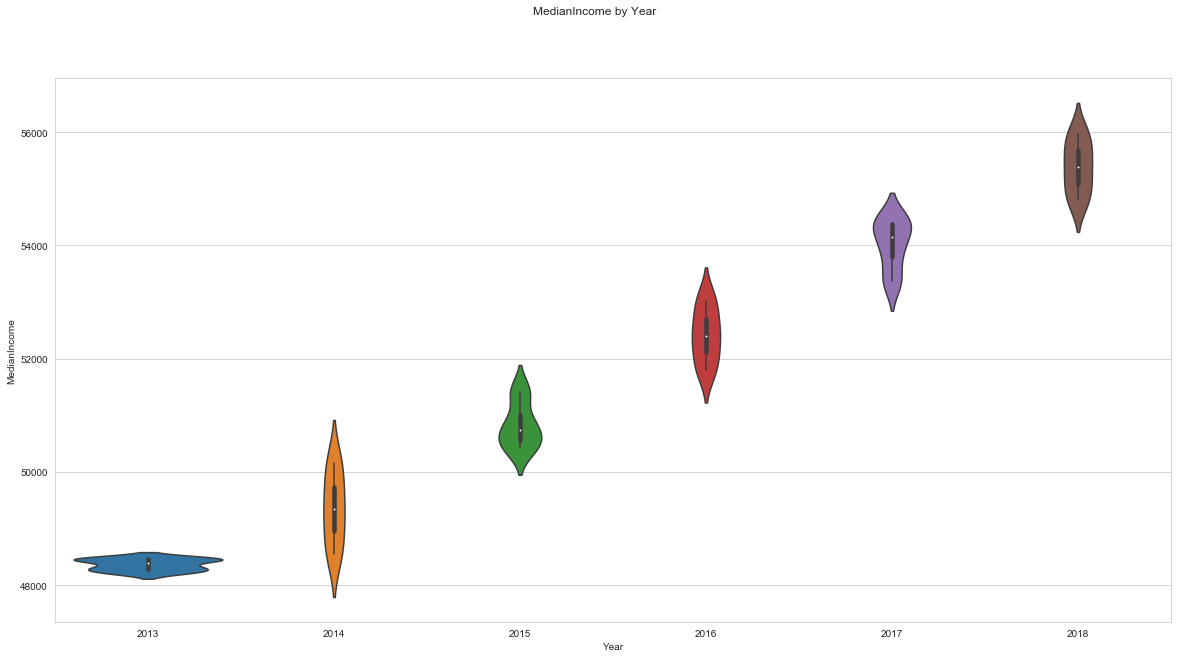

Year  Month  Quarter  RentalRateSqFt  UnemploymentRate  \
Date                                                                 
2013-01-01  2013      1        1        0.817461               7.4   
2013-02-01  2013      2        1        0.821955               7.0   
2013-03-01  2013      3        1        0.831094               6.9   
2013-04-01  2013      4        2        0.831767               6.9   
2013-05-01  2013      5        2        0.830218               6.8   

            RentalRate  MortgageRate  Listings  SaleCounts  SalePrices  \
Date                                                                     
2013-01-01      1250.0          3.46   18950.5      2118.0    189500.0   
2013-02-01      1250.0          3.58   18459.0      1870.0    188400.0   
2013-03-01      1288.0          3.59   19230.5      2348.0    189300.0   
2013-04-01      1295.0          3.42   20254.0      2951.0    191500.0   
2013-05-01      1300.0          3.59   21811.0      3331.0    192150.0   

            MedianIncome  
Date                      
2013-01-01     48236.435  
2013-02-01     48236.435  
2013-03-01     48236.435  
2013-04-01     48455.295  
2013-05-01     48455.295

In [101]:
#hideme
title = 'MedianIncome by Year'

plt.figure(figsize=(20,10))

sns.set_style("whitegrid")
sns.set_style({'axes.grid':True})

df = metrics_yearly.copy()

sns.violinplot(x=df['Year'],y=df['MedianIncome'],data=df)

plt.suptitle(f'{title}')

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
df.head()

![MedianIncome by Year](figures/MedianIncome_by_Year.png)

## ANOVA testing of Hypothesis
### Null Hypothysis "Unemployment Rate has no correlation to Rental Rates"

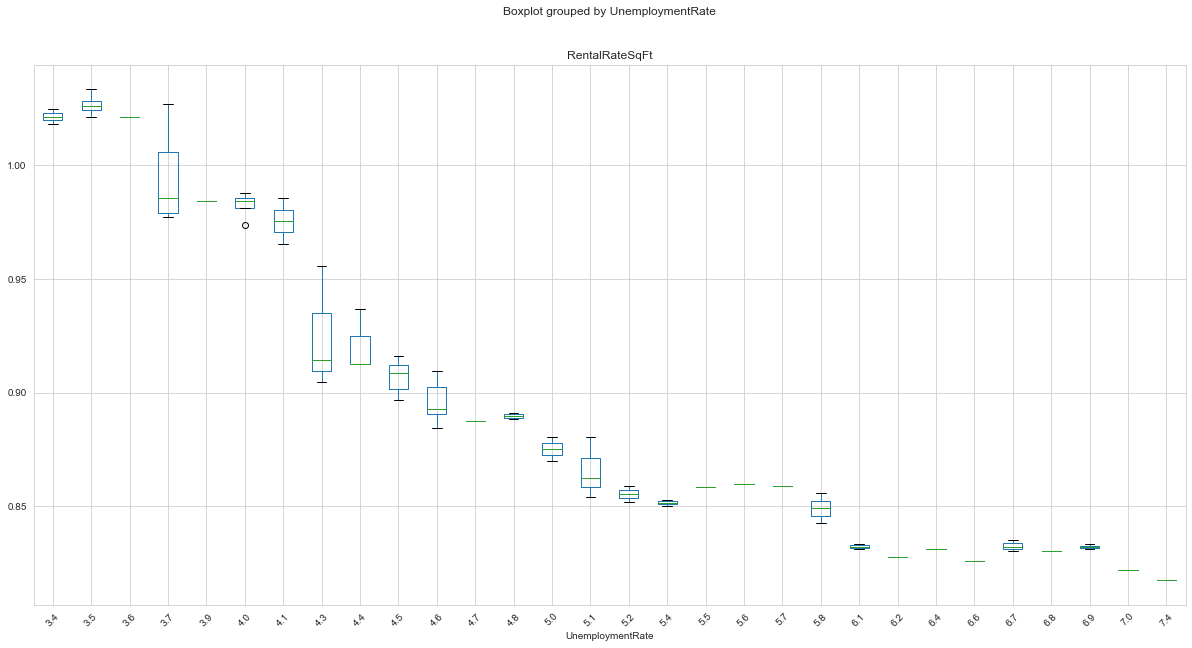

In [102]:
#hideme
title = 'ANOVA Boxplot - RentalRateSqFt vs Unemployment'

metrics_yearly_anova_emp = metrics_yearly.filter(items=['RentalRateSqFt','UnemploymentRate']).copy()
#remove any nan values
metrics_yearly_anova_emp = metrics_yearly_anova_emp.dropna()
metrics_yearly_anova_emp['UnemploymentRate'] = metrics_yearly_anova_emp['UnemploymentRate'].round(decimals=2)
metrics_yearly_anova_emp.boxplot("RentalRateSqFt", by="UnemploymentRate", figsize=(20, 10), rot=45)

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()

![ANOVA Boxplot - RentalRateSqFt vs Unemployment](figures/ANOVA_Boxplot_-_RentalRateSqFt_vs_Unemployment.png)

In [103]:
groups = metrics_yearly_anova_emp['UnemploymentRate'].unique()
groups

array([7.4, 7. , 6.9, 6.8, 6.7, 6.6, 6.4, 6.2, 6.1, 5.8, 5.5, 5.6, 5.7,
       5.4, 5.2, 5.1, 5. , 4.8, 4.6, 4.7, 4.5, 4.4, 4.3, 4.1, 4. , 3.9,
       3.7, 3.6, 3.5, 3.4])

In [104]:
stats.f_oneway(*[metrics_yearly_anova_emp[metrics_yearly_anova_emp["UnemploymentRate"] == grp]["RentalRateSqFt"] for grp in groups])

F_onewayResult(statistic=79.66967201737702, pvalue=2.2620372064918147e-28)

## ANOVA testing of Hypothesis
### Null Hypothysis "Median Income has no correlation to Rental Rates"

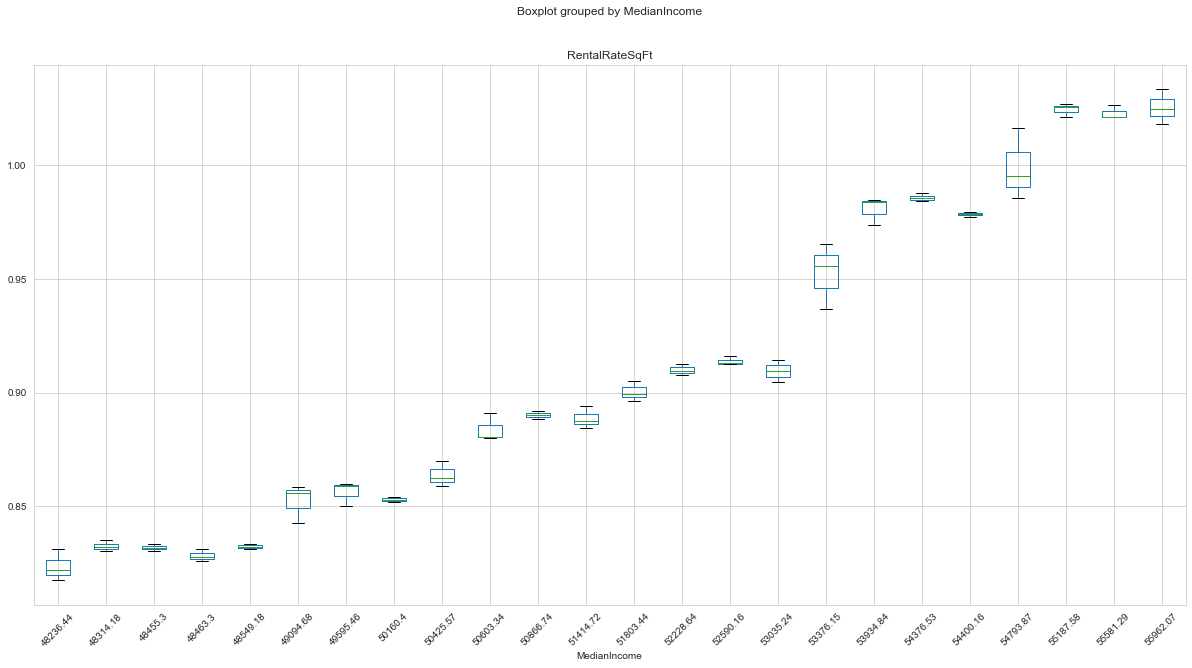

In [105]:
#hideme
title = 'ANOVA Boxplot - RentalRateSqFt vs MedianIncome'

metrics_yearly_anova_inc = metrics_yearly.filter(items=['RentalRateSqFt','MedianIncome']).copy()
#remove any nan values
#metrics_yearly_anova_inc = metrics_yearly_anova_inc.dropna()
metrics_yearly_anova_inc['MedianIncome'] = metrics_yearly_anova_inc['MedianIncome'].round(decimals=2)
metrics_yearly_anova_inc.boxplot("RentalRateSqFt", by="MedianIncome", figsize=(20, 10), rot=45)

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()

![ANOVA Boxplot - RentalRateSqFt vs MedianIncome](figures/ANOVA_Boxplot_-_RentalRateSqFt_vs_MedianIncome.png)

In [106]:
groups = metrics_yearly_anova_inc['MedianIncome'].unique()
groups

array([48236.44, 48455.3 , 48314.18, 48463.3 , 48549.18, 49094.68,
       49595.46, 50160.4 , 50425.57, 50603.34, 50866.74, 51414.72,
       51803.44, 52228.64, 52590.16, 53035.24, 53376.15, 53934.84,
       54376.53, 54400.16, 54793.87, 55187.58, 55581.29, 55962.07])

In [107]:
stats.f_oneway(*[metrics_yearly_anova_inc[metrics_yearly_anova_inc["MedianIncome"] == grp]["RentalRateSqFt"] for grp in groups])

F_onewayResult(statistic=384.5884229347032, pvalue=8.331698465058281e-47)

# Additional Observations

### Affordability Index - Monthly
>**pti** - Price To Income Index <br>
**mga** - Mortgage Affordability Index <br>
**rta** - Rent Affordability Index <br>

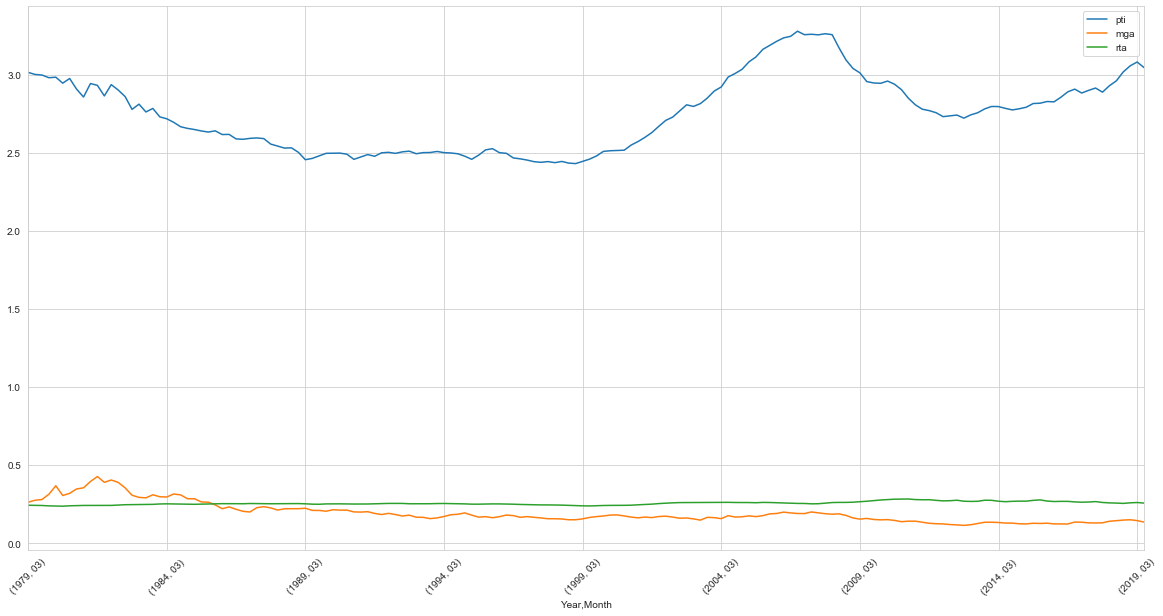

Year                                                                                                           1979  \
Month                                                                                                            03   
Index           State City                           RegionID RegionName                         SizeRank             
Price To Income  NY   New York                       394913   New York, NY                       1         2.928344   
                 CA   Los Angeles-Long Beach-Anaheim 753899   Los Angeles-Long Beach-Anaheim, CA 2         4.019673   
                 IL   Chicago                        394463   Chicago, IL                        3         3.035758   
                 TX   Dallas-Fort Worth              394514   Dallas-Fort Worth, TX              4         3.887457   
                 PA   Philadelphia                   394974   Philadelphia, PA                   5         2.388489   

Year                                                                                                                 \
Month                                                                                                            06   
Index           State City                           RegionID RegionName                         SizeRank             
Price To Income  NY   New York                       394913   New York, NY                       1         2.956635   
                 CA   Los Angeles-Long Beach-Anaheim 753899   Los Angeles-Long Beach-Anaheim, CA 2         4.141217   
                 IL   Chicago                        394463   Chicago, IL                        3         3.045651   
                 TX   Dallas-Fort Worth              394514   Dallas-Fort Worth, TX              4         4.025835   
                 PA   Philadelphia                   394974   Philadelphia, PA                   5         2.387368   

Year                                                                                                                 \
Month                                                                                                            09   
Index           State City                           RegionID RegionName                         SizeRank             
Price To Income  NY   New York                       394913   New York, NY                       1         2.966927   
                 CA   Los Angeles-Long Beach-Anaheim 753899   Los Angeles-Long Beach-Anaheim, CA 2         4.208146   
                 IL   Chicago                        394463   Chicago, IL                        3         2.984501   
                 TX   Dallas-Fort Worth              394514   Dallas-Fort Worth, TX              4         4.101038   
                 PA   Philadelphia                   394974   Philadelphia, PA                   5         2.389267   

Year                                                                                                                 \
Month                                                                                                            12   
Index           State City                           RegionID RegionName                         SizeRank             
Price To Income  NY   New York                       394913   New York, NY                       1         2.961860   
                 CA   Los Angeles-Long Beach-Anaheim 753899   Los Angeles-Long Beach-Anaheim, CA 2         4.278269   
                 IL   Chicago                        394463   Chicago, IL                        3         2.973171   
                 TX   Dallas-Fort Worth              394514   Dallas-Fort Worth, TX              4         4.130605   
                 PA   Philadelphia                   394974   Philadelphia, PA                   5         2.398643   

Year                                                                                                           1980  \
Month                                                                

In [108]:
#hideme
title = 'Affordability Index by Year'
affordability_index = affordability_index_src.copy()
affordability_index['State'] = affordability_index["RegionName"].apply(lambda x: "".join(x.split(',')[1:]))
affordability_index['City'] = affordability_index["RegionName"].apply(lambda x: "".join(x.split(',')[0]))
affordability_index = affordability_index.drop(columns='HistoricAverage_1985thru1999')
affordability_index_us = affordability_index.query('City == "United States"')
affordability_index = affordability_index[~affordability_index['City'].str.contains("United States")]
affordability_index.set_index(['Index','State','City','RegionID','RegionName','SizeRank'],inplace=True)
affordability_index.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in affordability_index.columns],names=['Year','Month'])
affordability_index = affordability_index#.stack(level=1)

# quick chart
affordability_index.query("Index == 'Price To Income'").median().plot(rot=45, grid=True, label='pti')
affordability_index.query("Index == 'Mortgage Affordability'").median().plot(rot=45, grid=True, label='mga')
affordability_index.query("Index == 'Rent Affordability'").median().plot(rot=45, grid=True, label='rta', figsize=(20,10))

plt.legend(loc='best')

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()

affordability_index.head()

![Affordability Index by Year](figures/Affordability_Index_by_Year.png)

# Additional Observations
### Geodata Munging

In [109]:
#build state name / id xref
with open(state_geo) as json_file:
    state_geo_df = json.load(json_file)
state_geo_xref = json_normalize(state_geo_df['features']).filter(items=['id','properties.name'])
state_geo_xref = state_geo_xref.rename(columns={'id':'State','properties.name':'StateName'})#.set_index('State')
state_geo_xref.head()

State   StateName
0    AL     Alabama
1    AK      Alaska
2    AZ     Arizona
3    AR    Arkansas
4    CA  California

In [110]:
# create geodataframe and add centroids
gdf = gpd.GeoDataFrame.from_features(state_geo_df)
gdf['centroid_lon'] = gdf['geometry'].centroid.x
gdf['centroid_lat'] = gdf['geometry'].centroid.y
gdf.crs = {'init' :'epsg:4326'}
gdf.head()

geometry        name  \
0  POLYGON ((-87.359296 35.00118, -85.606675 34.9...     Alabama   
1  (POLYGON ((-131.602021 55.117982, -131.569159 ...      Alaska   
2  POLYGON ((-109.042503 37.000263, -109.04798 31...     Arizona   
3  POLYGON ((-94.473842 36.501861, -90.152536 36....    Arkansas   
4  POLYGON ((-123.233256 42.006186, -122.378853 4...  California   

   centroid_lon  centroid_lat  
0    -86.827783     32.789907  
1   -152.373738     64.227768  
2   -111.663296     34.293393  
3    -92.440920     34.898249  
4   -119.614389     37.253895

In [111]:
#merge w/ data points
median_rental_price_mfr_state_year = median_rental_price_sfr_src.copy()
median_rental_price_mfr_state_year = median_rental_price_mfr_state_year.merge(state_geo_xref, left_on='State', right_on='State')
median_rental_price_mfr_state_year.set_index(['RegionName','State','Metro','CountyName','SizeRank'],inplace=True)
median_rental_price_mfr_state_year.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in median_rental_price_mfr_state_year.columns],names=['Year','Month'])
median_rental_price_mfr_state_year = median_rental_price_mfr_state_year.stack().reset_index().groupby(['State','StateName']).median().drop(columns='SizeRank')
gdf_income_tax = gdf.merge(median_rental_price_mfr_state_year.reset_index(),how='right', left_on='name', right_on='StateName')
gdf_income_tax = gdf_income_tax.fillna(method='bfill',axis=1).dropna(how='all',axis=1)
gdf_income_tax.head()

geometry        name centroid_lon  \
0  POLYGON ((-87.359296 35.00118, -85.606675 34.9...     Alabama     -86.8278   
1  (POLYGON ((-131.602021 55.117982, -131.569159 ...      Alaska     -152.374   
2  POLYGON ((-109.042503 37.000263, -109.04798 31...     Arizona     -111.663   
3  POLYGON ((-94.473842 36.501861, -90.152536 36....    Arkansas     -92.4409   
4  POLYGON ((-123.233256 42.006186, -122.378853 4...  California     -119.614   

  centroid_lat State   StateName    2010     2011     2012     2013     2014  \
0      32.7899    AL     Alabama     980     1075      950      900      850   
1      64.2278    AK      Alaska  1882.5   1882.5     1900     1950     1975   
2      34.2934    AZ     Arizona    1060  1027.25  1068.75   1087.5  1143.75   
3      34.8982    AR    Arkansas  928.75   928.75     1150     1100     1150   
4      37.2539    CA  California    2825  1821.25  1866.25  1998.75  2173.75   

   2015    2016  2017     2018  
0   935     905   950  1118.75  
1  2095    1890  1600     1750  
2  1195    1173  1350   1497.5  
3  1125     995  1075     1050  
4  2300  2397.5  2625     2800

## MAP - Unemployment Rate (%)

In [112]:
#hideme
unemployment_rate_state = unemployment_rate_state_src.copy()
unemployment_rate_state.rename(columns={'State':'StateName'},inplace=True)
unemployment_rate_state = unemployment_rate_state.merge(state_geo_xref,left_on='StateName',right_on='StateName')
unemployment_rate_state.dropna(inplace=True)
years = [col for col in unemployment_rate_state.columns if col not in ['StateName','State']]


#render the map
map_name = 'Unemployment Rate (%)'
m = folium.Map([43, -100], zoom_start=4)

for year in years:
    yr = folium.Choropleth(
    geo_data=state_geo,
    data=unemployment_rate_state,
    columns=['State', year],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name= f'{year} - {map_name}',
    overlay=True,
    name = f'{year}'
    )
    m.add_child(yr)

m.add_child(folium.LayerControl())

m.save(f"maps\{map_name}.html")

m



## MAP - Median Income ($)

In [113]:
#hideme
affordability_income_map_median = affordability_income_src.copy()
affordability_income_map_median['State'] = affordability_income_map_median["RegionName"].apply(lambda x: "".join(x.split(',')[1:]))
affordability_income_map_median.drop(columns=['RegionName','RegionID','SizeRank'],inplace=True)
affordability_income_map_median = affordability_income_map_median.set_index('State')
affordability_income_map_median.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in affordability_income_map_median.columns],names=['Year','Month'])
affordability_income_map_median = affordability_income_map_median.stack()
affordability_income_map_median = affordability_income_map_median.groupby('State').median()
affordability_income_map_median = affordability_income_map_median.reset_index()
affordability_income_map_median['State'] = affordability_income_map_median['State'].str.strip()
affordability_income_map_median['State'] = affordability_income_map_median['State'].astype(str)
affordability_income_map_median = affordability_income_map_median.merge(state_geo_xref,left_on='State',right_on='State')

years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']

#render the map
map_name = 'Median Income ($)'
m = folium.Map([43, -100], zoom_start=4)

for year in years:
    yr = folium.Choropleth(
    geo_data=state_geo,
    data=affordability_income_map_median,
    columns=['State', year],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name= f'{year} - {map_name}',
    overlay=True,
    name = f'{year}'
    )
    m.add_child(yr)

m.add_child(folium.LayerControl())

m.save(f"maps\{map_name}.html")

m


## MAP - Median Rent ($) w/ Overlay 

In [114]:
#hideme

years = [col for col in gdf_income_tax.columns if col not in ['geometry','name','centroid_lon','centroid_lat','State','StateName']]

#render the map
map_name = 'Median Rent ($)'

m = folium.Map([43, -100], zoom_start=4)

for year in years:
    yr = folium.Choropleth(
    geo_data=state_geo,
    data=gdf_income_tax,
    columns=['State', year],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name= f'{year} - {map_name}',
    #overlay=True,
    name = year
    )
    m.add_child(yr)
    # add markers with basic information
    fg = folium.FeatureGroup(name=f'{year}-Rent')
    for lat, lon, val, name in zip(gdf_income_tax['centroid_lat'].tolist(), gdf_income_tax['centroid_lon'].tolist(), gdf_income_tax[year].tolist(), gdf_income_tax['name'].tolist()):
        html = f"""
        <h2>{name}<\h2><br>
        <h4>Median Rent ({year}): {int(round(val,0))} HUF <\h4>
        """
        fg.add_child(folium.Marker(location=[lat, lon], popup=html))
    m.add_child(fg)

folium.LayerControl().add_to(m)

m.save(f"maps\{map_name}.html")

m